<h2>Exercise 2 - Fact Checking</h2>

In [23]:
import pandas as pd
import numpy as np
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt

In [24]:
performances = {'Accuracies': {}, 'Recalls': {} , 'Precisions': {} , 'F1-Scores': {}}

<h4>Read and preprocess datasets</h4>

In [25]:
ds1 = pd.read_csv('../fake_or_real_news.csv', sep=',', usecols=['title','text','label'])
ds1['claim'] = ds1[['title', 'text']].apply(lambda x: '. '.join(x), axis=1)
del ds1['title']
del ds1['text']
ds1.rename(index=str, columns={'label': 'y'}, inplace=True)
ds1['y'] = np.where(ds1['y'] == 'FAKE', 'false', 'true')
ds1.head()

,y,claim
0,false,You Can Smell Hillary’s Fear. Daniel Greenfiel...
1,false,Watch The Exact Moment Paul Ryan Committed Pol...
2,true,Kerry to go to Paris in gesture of sympathy. U...
3,false,Bernie supporters on Twitter erupt in anger ag...
4,true,The Battle of New York: Why This Primary Matte...


In [26]:
ds2_train = pd.read_csv('../liar_liar_paints_on_fire/train.tsv', sep='\t', header=None, usecols=[1,2], names=['y', 'claim'])
ds2_valid = pd.read_csv('../liar_liar_paints_on_fire/valid.tsv', sep='\t', header=None, usecols=[1,2], names=['y', 'claim'])
ds2_test = pd.read_csv('../liar_liar_paints_on_fire/test.tsv', sep='\t', header=None, usecols=[1,2], names=['y', 'claim'])

# consider only "true" and "false" labels
ds2_train=ds2_train[(ds2_train['y'] == 'true') | (ds2_train['y'] == 'false')]
ds2_valid=ds2_valid[(ds2_valid['y'] == 'true') | (ds2_valid['y'] == 'false')]
ds2_test=ds2_test[(ds2_test['y'] == 'true') | (ds2_test['y'] == 'false')]

ds2_train.shape

(3671, 2)

In [27]:
ds3=pd.concat([ds1, ds2_train, ds2_valid, ds2_test], ignore_index=True)
ds3.shape

(10895, 2)

<h4>Configuration 1: Apply model A (the baseline classifier) on dataset 1 and report training and test accuracy</h4>

In [28]:
# 5-fold cross-validation
ss = KFold(n_splits=5, random_state=4222)
accuraciesTrain = []
recallsTrain = []
precisionsTrain = []
f1scoresTrain = []

accuraciesTest = []
recallsTest = []
precisionsTest = []
f1scoresTest = []
    
for train_indices, test_indices in ss.split(ds1['claim'], ds1['y']):
    #feature extraction with TFIDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
    tfidf_train = tfidf_vectorizer.fit_transform(ds1['claim'][train_indices])
    tfidf_test = tfidf_vectorizer.transform(ds1['claim'][test_indices])
    
    #train the classifier and get predictions for training and test set
    clf = LogisticRegression()
    clf.fit(tfidf_train, ds1['y'][train_indices])
    predTrain = clf.predict(tfidf_train)
    predTest = clf.predict(tfidf_test)
    
    #evaluate the results
    accuraciesTrain.append(metrics.accuracy_score(ds1['y'][train_indices], predTrain))
    recallsTrain.append(metrics.recall_score(ds1['y'][train_indices], predTrain, pos_label='true'))
    precisionsTrain.append(metrics.precision_score(ds1['y'][train_indices], predTrain, pos_label='true'))
    f1scoresTrain.append(metrics.f1_score(ds1['y'][train_indices], predTrain, pos_label='true'))
    
    accuraciesTest.append(metrics.accuracy_score(ds1['y'][test_indices], predTest))
    recallsTest.append(metrics.recall_score(ds1['y'][test_indices], predTest, pos_label='true'))
    precisionsTest.append(metrics.precision_score(ds1['y'][test_indices], predTest, pos_label='true'))
    f1scoresTest.append(metrics.f1_score(ds1['y'][test_indices], predTest, pos_label='true'))
    
#average the results
print("Training results:")
print("accuracy:   %0.3f" % np.mean(accuraciesTrain))
print("recall:   %0.3f" % np.mean(recallsTrain))
print("precision:   %0.3f" % np.mean(precisionsTrain))
print("f1-score:   %0.3f" % np.mean(f1scoresTrain))

print("\nTest results:")
print("accuracy:   %0.3f" % np.mean(accuraciesTest))
print("recall:   %0.3f" % np.mean(recallsTest))
print("precision:   %0.3f" % np.mean(precisionsTest))
print("f1-score:   %0.3f" % np.mean(f1scoresTest))

performances['Accuracies'].update({'configuration1': np.mean(accuraciesTest)})
performances['Recalls'].update({'configuration1': np.mean(recallsTest)})
performances['Precisions'].update({'configuration1': np.mean(precisionsTest)})
performances['F1-Scores'].update({'configuration1': np.mean(f1scoresTest)})

Training results:
accuracy:   0.958
recall:   0.946
precision:   0.969
f1-score:   0.957

Test results:
accuracy:   0.915
recall:   0.888
precision:   0.939
f1-score:   0.913


<h4>Configuration 2: Modify the baseline and run it on dataset 2 (training, validation and test set)</h4>

In [67]:
# feature extraction with hashing vectorizer
hash_vectorizer = HashingVectorizer()
hash_train = hash_vectorizer.fit_transform(ds2_train['claim'])
hash_valid = hash_vectorizer.transform(ds2_valid['claim'])
hash_test = hash_vectorizer.transform(ds2_test['claim'])
    
#train the classifier and get predictions for training and test set
clf = LogisticRegression()
clf.fit(hash_train, ds2_train['y'])
predTrain = clf.predict(hash_train)
predValid = clf.predict(hash_valid)
predTest = clf.predict(hash_test)

# get results for all 3 sets
accuracyTrain = metrics.accuracy_score(ds2_train['y'], predTrain)
recallTrain = metrics.recall_score(ds2_train['y'], predTrain, pos_label='true')
precisionTrain = metrics.precision_score(ds2_train['y'], predTrain, pos_label='true')
f1scoreTrain = metrics.f1_score(ds2_train['y'], predTrain, pos_label='true')

accuracyValid = metrics.accuracy_score(ds2_valid['y'], predValid)
recallValid = metrics.recall_score(ds2_valid['y'], predValid, pos_label='true')
precisionValid = metrics.precision_score(ds2_valid['y'], predValid, pos_label='true')
f1scoreValid = metrics.f1_score(ds2_valid['y'], predValid, pos_label='true')

accuracyTest = metrics.accuracy_score(ds2_test['y'], predTest)
recallTest = metrics.recall_score(ds2_test['y'], predTest, pos_label='true')
precisionTest = metrics.precision_score(ds2_test['y'], predTest, pos_label='true')
f1scoreTest = metrics.f1_score(ds2_test['y'], predTest, pos_label='true')

print("Training results:")
print("accuracy:   %0.3f" % accuracyTrain)
print("recall:   %0.3f" % recallTrain)
print("precision:   %0.3f" % precisionTrain)
print("f1-score:   %0.3f" % f1scoreTrain)

print("\nValidation results:")
print("accuracy:   %0.3f" % accuracyValid)
print("recall:   %0.3f" % recallValid)
print("precision:   %0.3f" % precisionValid)
print("f1-score:   %0.3f" % f1scoreValid)

print("\nTest results:")
print("accuracy:   %0.3f" % accuracyTest)
print("recall:   %0.3f" % recallTest)
print("precision:   %0.3f" % precisionTest)
print("f1-score:   %0.3f" % f1scoreTest)

performances['Accuracies'].update({'configuration 2':accuracyTest})
performances['Recalls'].update({'configuration 2': recallTest})
performances['Precisions'].update({'configuration 2': precisionTest})
performances['F1-Scores'].update({'configuration 2': f1scoreTest})

Training results:
accuracy:   0.767
recall:   0.673
precision:   0.787
f1-score:   0.725

Validation results:
accuracy:   0.692
recall:   0.580
precision:   0.613
f1-score:   0.596

Test results:
accuracy:   0.630
recall:   0.524
precision:   0.609
f1-score:   0.563


<h4>Configuration 3: Run both model a and b on the complete datasets 1 and 2</h4>

In [30]:
######### model a on dataset 2 #############

#feature extraction with TFIDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(ds1['claim'])
tfidf_test = tfidf_vectorizer.transform(ds2_test['claim'])

#train the classifier and get predictions for training and test set
clf = LogisticRegression()
clf.fit(tfidf_train, ds1['y'])
predTest = clf.predict(tfidf_test)

#evaluate the results
accuracyTest = metrics.accuracy_score(ds2_test['y'], predTest)
recallTest = metrics.recall_score(ds2_test['y'], predTest, pos_label='true')
precisionTest = metrics.precision_score(ds2_test['y'], predTest, pos_label='true')
f1scoreTest = metrics.f1_score(ds2_test['y'], predTest, pos_label='true')

print("\nTest results:")
print("accuracy:   %0.3f" % accuracyTest)
print("recall:   %0.3f" % recallTest)
print("precision:   %0.3f" % precisionTest)
print("f1-score:   %0.3f" % f1scoreTest)

performances['Accuracies'].update({'configuration 3.1':accuracyTest})
performances['Recalls'].update({'configuration 3.1': recallTest})
performances['Precisions'].update({'configuration 3.1': precisionTest})
performances['F1-Scores'].update({'configuration 3.1': f1scoreTest})


Test results:
accuracy:   0.508
recall:   0.144
precision:   0.390
f1-score:   0.211


In [31]:
######### model b on dataset 1 ###########

# feature extraction with hashing vectorizer
hash_vectorizer = HashingVectorizer()
hash_train = hash_vectorizer.fit_transform(ds2_train['claim'])
hash_test = hash_vectorizer.transform(ds1['claim'])
    
#train the classifier and get predictions for training and test set
clf = LogisticRegression()
clf.fit(hash_train, ds2_train['y'])
predTrain = clf.predict(hash_train)
predTest = clf.predict(hash_test)

# get results
accuracyTest = metrics.accuracy_score(ds1['y'], predTest)
recallTest = metrics.recall_score(ds1['y'], predTest, pos_label='true')
precisionTest = metrics.precision_score(ds1['y'], predTest, pos_label='true')
f1scoreTest = metrics.f1_score(ds1['y'], predTest, pos_label='true')

print("\nTest results:")
print("accuracy:   %0.3f" % accuracyTest)
print("recall:   %0.3f" % recallTest)
print("precision:   %0.3f" % precisionTest)
print("f1-score:   %0.3f" % f1scoreTest)

performances['Accuracies'].update({'configuration 3.2':accuracyTest})
performances['Recalls'].update({'configuration 3.2': recallTest})
performances['Precisions'].update({'configuration 3.2': precisionTest})
performances['F1-Scores'].update({'configuration 3.2': f1scoreTest})


Test results:
accuracy:   0.562
recall:   0.703
precision:   0.548
f1-score:   0.616


<h4>Configuration 4: Run the model on the joint dataset 3</h4>

In [32]:
# 5-fold cross-validation
ss = KFold(n_splits=5, random_state=4222)
accuraciesTrain = []
recallsTrain = []
precisionsTrain = []
f1scoresTrain = []

accuraciesTest = []
recallsTest = []
precisionsTest = []
f1scoresTest = []
    
for train_indices, test_indices in ss.split(ds3['claim'], ds3['y']):
    #feature extraction with count vectorizer
    count_vectorizer = CountVectorizer()
    count_train = count_vectorizer.fit_transform(ds3['claim'][train_indices])
    count_test = count_vectorizer.transform(ds3['claim'][test_indices])
    
    #train the classifier and get predictions for training and test set
    clf = MultinomialNB(alpha=.01)
    clf.fit(count_train, ds3['y'][train_indices])
    predTrain = clf.predict(count_train)
    predTest = clf.predict(count_test)
    
    #evaluate the results
    accuraciesTrain.append(metrics.accuracy_score(ds3['y'][train_indices], predTrain))
    recallsTrain.append(metrics.recall_score(ds3['y'][train_indices], predTrain, pos_label='true'))
    precisionsTrain.append(metrics.precision_score(ds3['y'][train_indices], predTrain, pos_label='true'))
    f1scoresTrain.append(metrics.f1_score(ds3['y'][train_indices], predTrain, pos_label='true'))
    
    accuraciesTest.append(metrics.accuracy_score(ds3['y'][test_indices], predTest))
    recallsTest.append(metrics.recall_score(ds3['y'][test_indices], predTest, pos_label='true'))
    precisionsTest.append(metrics.precision_score(ds3['y'][test_indices], predTest, pos_label='true'))
    f1scoresTest.append(metrics.f1_score(ds3['y'][test_indices], predTest, pos_label='true'))
    
#average the results
print("Training results:")
print("accuracy:   %0.3f" % np.mean(accuraciesTrain))
print("recall:   %0.3f" % np.mean(recallsTrain))
print("precision:   %0.3f" % np.mean(precisionsTrain))
print("f1-score:   %0.3f" % np.mean(f1scoresTrain))

print("\nTest results:")
print("accuracy:   %0.3f" % np.mean(accuraciesTest))
print("recall:   %0.3f" % np.mean(recallsTest))
print("precision:   %0.3f" % np.mean(precisionsTest))
print("f1-score:   %0.3f" % np.mean(f1scoresTest))

performances['Accuracies'].update({'configuration 4': np.mean(accuraciesTest)})
performances['Recalls'].update({'configuration 4': np.mean(recallsTest)})
performances['Precisions'].update({'configuration 4': np.mean(precisionsTest)})
performances['F1-Scores'].update({'configuration 4': np.mean(f1scoresTest)})

Training results:
accuracy:   0.815
recall:   0.899
precision:   0.760
f1-score:   0.823

Test results:
accuracy:   0.727
recall:   0.823
precision:   0.705
f1-score:   0.753


<h4>Plot test results for all configurations</h4>

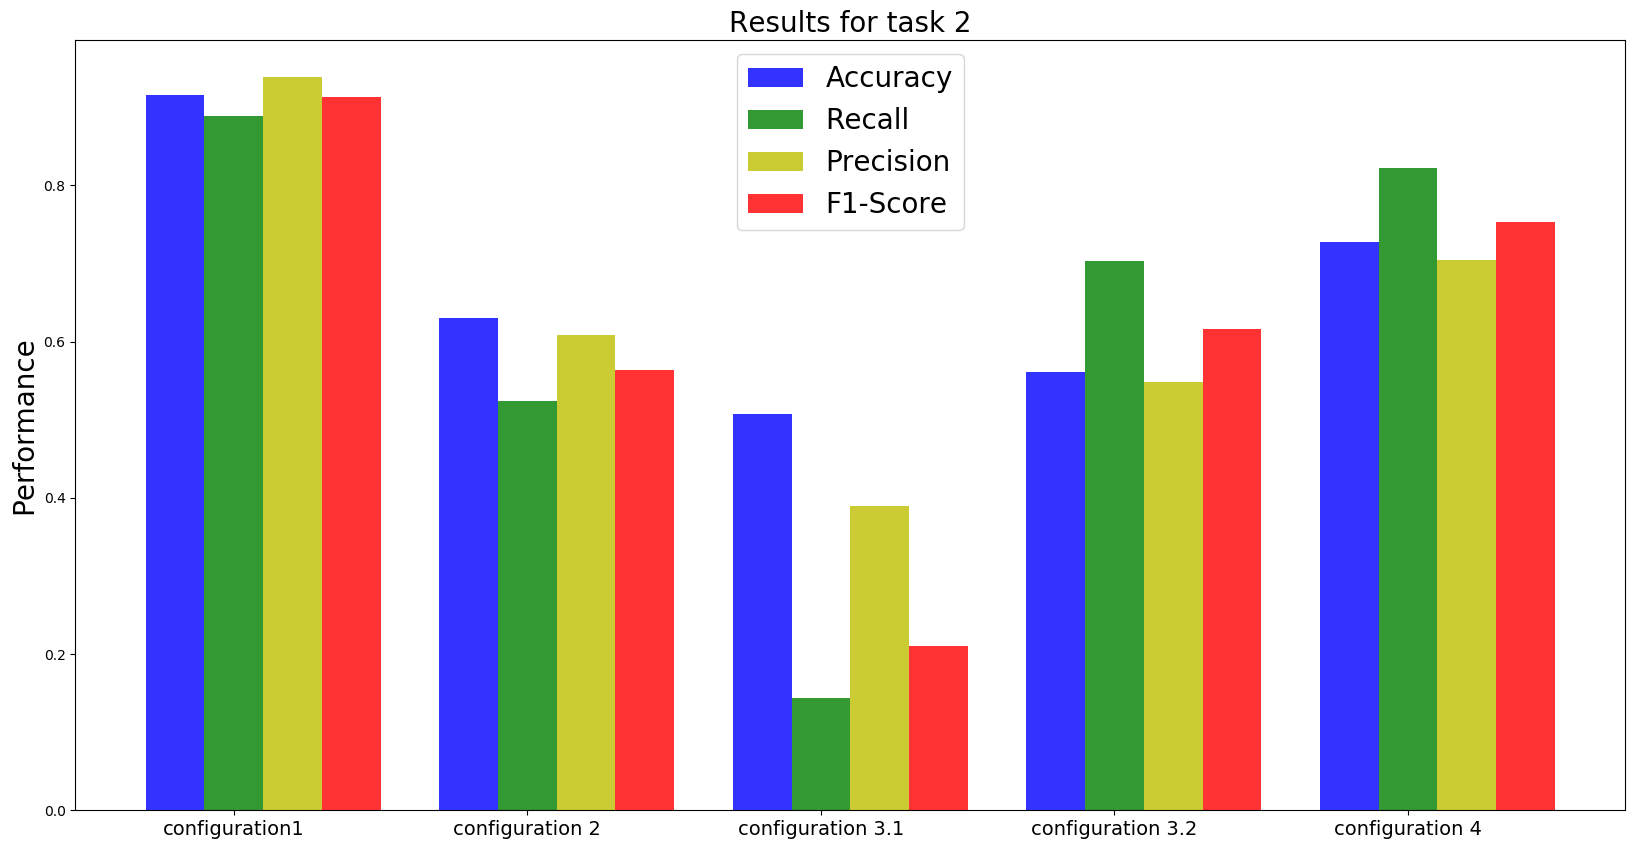

In [38]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import numpy as np

# data to plot
n_groups = 5
accuracies = list(performances['Accuracies'].values())
recalls = list(performances['Recalls'].values())
precisions = list(performances['Precisions'].values())
f1scores = list(performances['F1-Scores'].values())
 
# create plot
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(n_groups)
bar_width = 0.2
opacity = 0.8
 
rects1 = plt.bar(index, accuracies, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Accuracy')
 
rects2 = plt.bar(index + bar_width, recalls, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Recall')

rects3 = plt.bar(index + 2*bar_width, precisions, bar_width,
                 alpha=opacity,
                 color='y',
                 label='Precision')
 
rects4 = plt.bar(index + 3*bar_width, f1scores, bar_width,
                 alpha=opacity,
                 color='r',
                 label='F1-Score')
 
plt.ylabel('Performance', fontsize=20)
plt.title('Results for task 2', fontsize=20)
plt.xticks(index + bar_width, list(performances['Accuracies'].keys()), fontsize=14)
plt.legend(prop={'size': 20})

plt.show()